In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import stats
from statistics import mean

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
connect = engine.connect()

# Exploratory Climate Analysis

In [12]:
# Review the information in the Measurement table
first_row = session.query(Measurement).first()
# View the column names as a dictionary
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1eacd92af28>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [20]:
# Review the information in the Station table
first_row = session.query(Station).first()
# View the column names as a dictionary
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1eacda211d0>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform query to find the last day
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day



('2017-08-23')

In [68]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [69]:
# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

In [70]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precip_scores)

In [71]:
precipitation_df

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [72]:
# Set the index to a date column
precipitation_df.set_index('date', inplace=True)

precipitation_df

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [73]:
# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)

#Rename the legend
precipitation_df.rename(columns = {'prcp' : 'precipitation'}, inplace = True)

In [74]:
# Set x axis and tick locations

## Attempt to get the dates to display Vertical; I could not get this to work.
# x_axis = np.arange(len(precipitation_df))
# tick_locations = [value for value in x_axis]

# plt.xticks(tick_locations, precipitation_df["date"], rotation="vertical")

C:\Users\Scott Proveucher\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<function matplotlib.pyplot.show(close=None, block=None)>

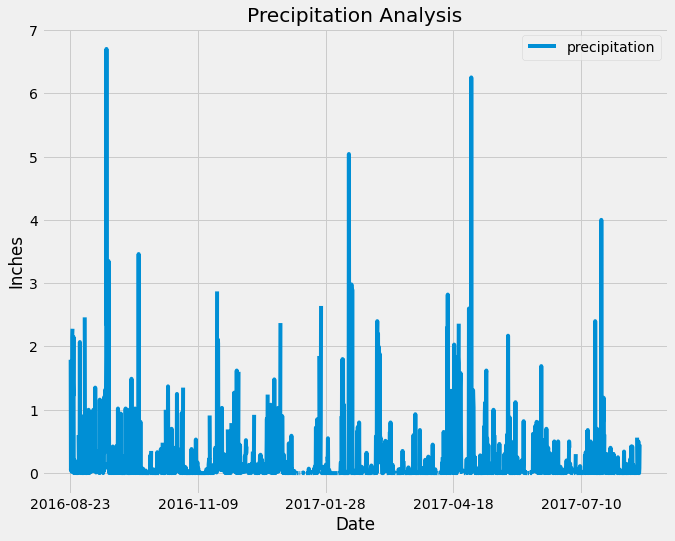

In [75]:
# Use Pandas Plotting with Matplotlib to plot the data
ax3 = precipitation_df.plot(figsize=(10,8))

plt.title("Precipitation Analysis")
plt.xlabel("Date")
plt.ylabel("Inches")

plt.savefig('Images/Precipitation_data.png')
plt.show

In [57]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [58]:
# Design a query to show how many stations are available in this dataset?
unique_stations = session.query(Station.station).\
    group_by(Station.station).count()

print(f'The number of unique stations in this database is: {unique_stations}')

The number of unique stations in this database is: 9


In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_rows = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_rows:
    print(f"{result[0]}\tCount: {result[1]}")

USC00519281	Count: 2772
USC00519397	Count: 2724
USC00513117	Count: 2709
USC00519523	Count: 2669
USC00516128	Count: 2612
USC00514830	Count: 2202
USC00511918	Count: 1979
USC00517948	Count: 1372
USC00518838	Count: 511


In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = 'USC00519281'
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
print(f"Lowest Temperature: {most_active_temps[0][0]} Fahrenheit, Highest Temperature: {most_active_temps[0][1]} Fahrenheit, Average Temperature: {most_active_temps[0][2]} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit, Highest Temperature: 85.0 Fahrenheit, Average Temperature: 71.66378066378067 Fahrenheit


In [64]:
# Choose the station with the highest number of temperature observations.
year_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stations_temps_df = pd.DataFrame(year_temps, columns = ['date', 'temperature'])

In [65]:
# Set the index to a date column
stations_temps_df.set_index('date', inplace = True)

stations_temps_df

,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


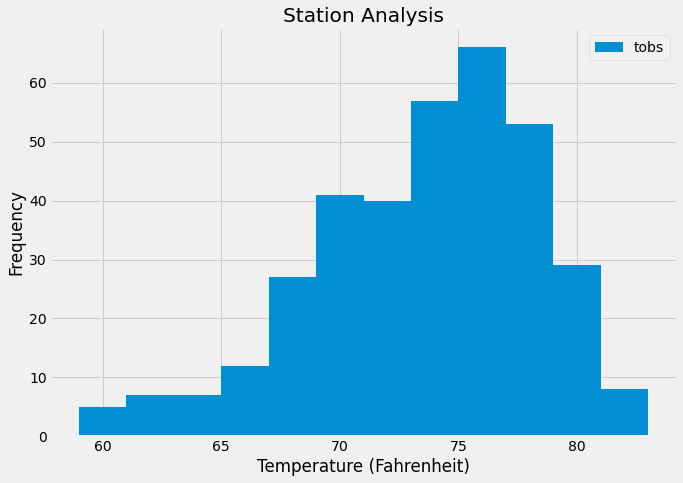

In [85]:
# Plot the results as a histogram
num_bins = 12
fig, ax = plt.subplots(figsize=(10,7))

n, bins, patches = ax.hist(stations_temps_df, num_bins)
#stations_temps_df.plot.hist(num_bins, ax = ax)

ax.set_title('Station Analysis')
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')

ax.legend(['tobs'],loc='best')

plt.savefig('Images/Station_histogram.png')
plt.show()


## Bonus Challenge Assignment

In [89]:
# Temperature Analysis I
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

In [94]:
# Identify the average temperature in June at all stations across all available years in the dataset.
june = "06"
june_temperature = session.query(Measurement.tobs).filter(func.strftime("%m",  Measurement.date) == june).all()

# Unpack the temperature and save into list
june_temperature_list = [temperature[0] for temperature in june_temperature]

# Average Temperature for June
june_mean = mean(june_temperature_list)
june_mean

74.94411764705882

In [95]:
# #Identify the average temperature in December at all stations across all available years in the dataset.
december = "12"
december_temperature = session.query(Measurement.tobs).filter(func.strftime("%m",  Measurement.date) == december).all()

# Unpack the temperature and save into list
december_temperature_list = [temperature[0] for temperature in december_temperature]

# Average Temperature for December
december_mean = mean(december_temperature_list)
december_mean

71.04152933421226

In [96]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?

# Unpaired (independent) t-test
stats.ttest_ind(june_temperature_list, december_temperature_list, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

In [87]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
